# Replicate stylized facts from "Segmented Arbitrage"

 - Start by replicating the correlation matrix heatmap
 - Extract principal components from the panel of basis trade returns and replicate their scree plot. 
 
Then, continue with a few of our own exporations. 
 - Extract the factor scores.
 - Then use the factor scores and compare them hedge fund returns

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from settings import config
import load_bases_data

MANUAL_DATA_DIR = config("MANUAL_DATA_DIR")
OUTPUT_DIR = config("OUTPUT_DIR")

In [2]:
df = load_bases_data.load_combined_spreads_wide(data_dir=MANUAL_DATA_DIR)
df = df.ffill(limit=5).dropna()
# df.info()

## Arbitrage Spreads

In [3]:
bar_df = pd.Series(dtype=float)
bar_df['CDS-Bond'] = -df[["CDS_Bond_HY", "CDS_Bond_IG"]].mean().mean()
bar_df['Equity-SF'] = df[['Eq_SF_Dow', 'Eq_SF_NDAQ', 'Eq_SF_SPX']].mean().mean()
bar_df['Box'] = df[['Box_06m', 'Box_12m', 'Box_18m']].mean().mean()
bar_df['Tips-Treas'] = df[[
    "TIPS_Treasury_10Y", "TIPS_Treasury_02Y", "TIPS_Treasury_20Y", "TIPS_Treasury_05Y",]
    ].mean().mean()
bar_df['CIP'] = df[[
    'CIP_AUD', 'CIP_CAD', 'CIP_EUR', 'CIP_GBP', 'CIP_JPY', 'CIP_NZD', 'CIP_SEK', ]
    ].mean().mean()
bar_df['Treas-Swap'] = -df[
    ['Treasury_Swap_01Y', 'Treasury_Swap_02Y', 'Treasury_Swap_03Y', 
     'Treasury_Swap_05Y', 'Treasury_Swap_10Y', 'Treasury_Swap_20Y', 
     'Treasury_Swap_30Y',
     ]].mean().mean()
bar_df['Treas-SF'] = df[[
    'Treasury_SF_02Y', 'Treasury_SF_05Y', 'Treasury_SF_10Y', 'Treasury_SF_30Y', 
     ]].mean().mean()
bar_df.index.name = 'Strategy'
bar_df.name = 'Average Arbitrage Spread (bps)'

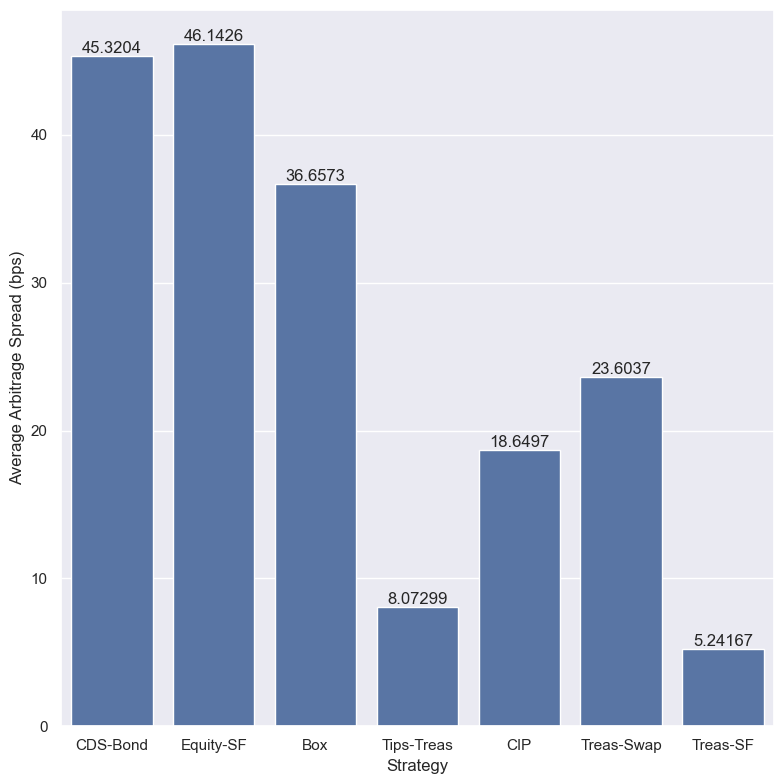

In [4]:
plt.figure(figsize=(8,8))
ax = sns.barplot(data=bar_df.reset_index(), x='Strategy', y='Average Arbitrage Spread (bps)')
ax.bar_label(ax.containers[0])
plt.tight_layout()

path = OUTPUT_DIR / 'arbitrage_spreads_ave.png'
plt.savefig(path, dpi=300)

## Correlation Matrix Heatmap

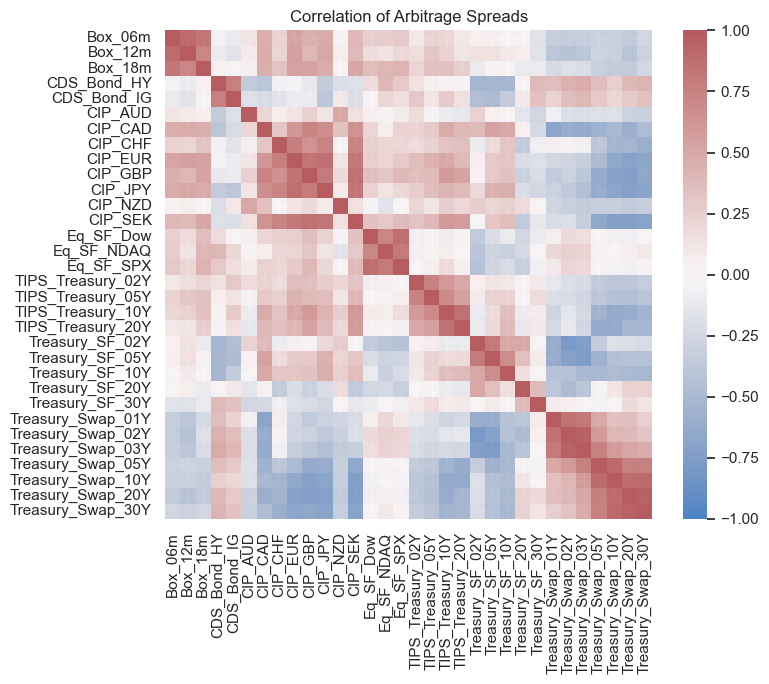

In [5]:
plt.figure(figsize=[8,7])
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='vlag', xticklabels=True, yticklabels=True, alpha=.8)
plt.title('Correlation of Arbitrage Spreads')
plt.tight_layout()

path = OUTPUT_DIR / 'arbitrage_spreads_corr.png'
plt.savefig(path, dpi=300)

## Scree plots

In [6]:
balanced_df = df.dropna()
shape = balanced_df.shape
print(shape)
print(f'Starting date in balanced panel: {balanced_df.index[0]}')
print(f'Ending date in balanced panel: {balanced_df.index[-1]}')

(1923, 32)
Starting date in balanced panel: 2011-09-27 00:00:00
Ending date in balanced panel: 2020-10-06 00:00:00


In [7]:
def calc_cumulative_explained_variance(balanced_df, multiply_100=True, include_zero=True):
    num_vars = balanced_df.shape[1]
    pca = PCA(n_components=num_vars)
    pca.fit(balanced_df)
    if multiply_100:
        scale = 100
    explained_variance = np.cumsum(pca.explained_variance_ratio_) * 100
    if include_zero:
        explained_variance = [np.nan, *explained_variance]
    return explained_variance

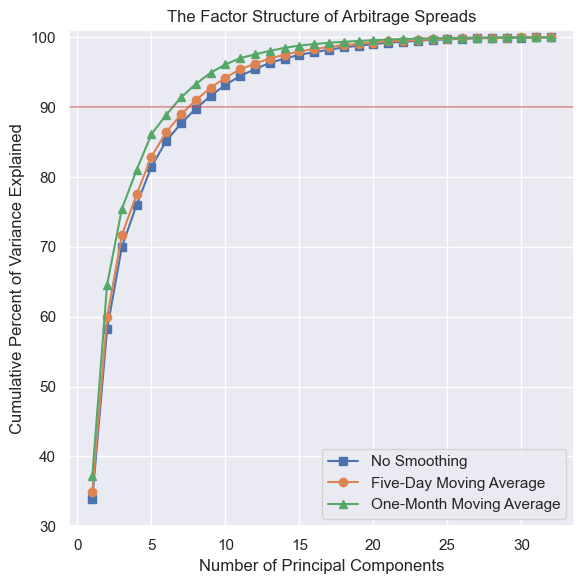

In [8]:
plt.figure(figsize=(6,6))
cev = calc_cumulative_explained_variance(balanced_df)
plt.plot(cev, marker='s', label='No Smoothing')
cev5 = calc_cumulative_explained_variance(balanced_df.rolling(5).mean().dropna())
plt.plot(cev5, marker='o', label='Five-Day Moving Average')
cev30 = calc_cumulative_explained_variance(balanced_df.rolling(30).mean().dropna())
plt.plot(cev30, marker='^', label='One-Month Moving Average')
plt.axhline(y=90, color='r', alpha=.5)
plt.ylim((30,101))
plt.title('The Factor Structure of Arbitrage Spreads')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Percent of Variance Explained')
plt.legend()
plt.tight_layout()

path = OUTPUT_DIR / 'arbitrage_spreads_pca_cumvariance.png'
plt.savefig(path, dpi=300)

From the plot above, we can see that a lot of the uncorrelated variation is coming from the arbitrage spreads that are still missing from our replication versus the original authors' analysis. That is, we are missing the following spreads:

 - Treasury 20 Y
 - TIPS-Treasury Basis
 - CDS-Bond HY
 - CDS-Bond IG
 - CHF CIP

 The original authors make the point that they need 10 principal components to explain approximately 90\% of the data. With the spreads that we have now, we need 5. We are missing 5 spreads, so these remaining spreads must be very dissimilar from the rest. The period of time that we cover is slightly shorter, but only slightly. So, this may have a slight effect as well.